<b> Problem 1.</b> In this problem we will consider a subset of the MovieLens dataset which contains user ratings for $M$ movies, recorded between $1$ and $5$, for $N$ users.  In our subset, $M=500$ and $N=943$. The training and test datasets represent the same users, but each dataset has different observed user-movie rating pairs.  We will investigate the behavior of factor analysis and PCA models for the prediction of the test ratings.

Denoting by $x_{ij}$ the rating user $i$ gives to movie $j$, factor analysis models the ratings vector $x_i$ for user $i$ by a latent $K$-dimensional vector $z_i \in \mathbb{R}^K$ via,
$$
p (z_i ) = \mathrm{Normal}(0, 1_K ), \qquad p(x_i | z_i ) = \mathrm{Normal}(W z_i + m, V)
$$
where $W$ is an $M \times K$ factor-loading matrix, $m$ is a $M$-dimensional mean vector and $V$ is a diagonal covariance matrix.

We will implement the EM-algorithm that alternately finds maximum-likelihood estimates for $W$, $m$ and $V$ and marginal distributions for hidden variables $z$. 

To evaluate the empirical performance of the various prediction methods, we will use the root mean square error (RMSE),
$$
RMSE := \left( \frac{1}{N_r} \sum_{i, j} r_{ij} (x_{ij} - \hat{x}_{ij} )^2 \right)^{\frac{1}{2}}
$$
where $r_{ij} =1$ iff $x_{ij}$ appears in the test dataset, and $N_r := \sum_{i, j} r_{ij}$.

<b> 1.a)</b> As a simple baseline use the mean rating of each movie in the training dataset to predict the test ratings.

In [8]:
import numpy as np
from scipy.io import loadmat
import imp
import hw9
import matplotlib.pyplot as plt
data = loadmat('movielens500.mat')
xTrain, xTest = data['S_train'], data['S_test']
rTrain = 1 - (xTrain==0)
rTest = 1- (xTest ==0)

In [5]:
means = np.sum(xTrain, axis=0) / np.sum(rTrain, axis=0)
err = hw9.RMS(means, xTest)
print('The RMSE using the mean training rating of each movie is: '+'{:.4f}'.format(err))

The RMSE using the mean training rating of each movie is: 1.0198


<b>1.b)</b> Next, we use a simple method based on PCA.  First, fill in the missing predictions using the mean predictions from (a).  Use PCA to predict the test ratings for $K= \{1, 2, \dots, 20\}$.  Plot RMSE vs $K$.

In [12]:
imp.reload(hw9)
pca = hw9.moviePCA()
pca.fit(xTrain)
n = 20
Kvals = np.arange(n)+1
rms = np.zeros(n)
for i in range(n):
    K = Kvals[i]
    rms[i] = hw9.RMS(pca.predict(K), xTest)

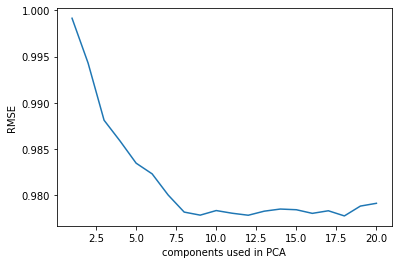

The value of K with the lowest RMSE is: 18
The best RMSE is: 0.9778


In [13]:
plt.plot(Kvals, rms)
plt.xlabel('components used in PCA')
plt.ylabel('RMSE')
plt.show()
i = np.argmin(rms)
print('The value of K with the lowest RMSE is:', Kvals[i])
print('The best RMSE is: '+'{:.4f}'.format(rms[i]))

<b>1.c)</b> Run the EM algorithm with factor analysis to estimate low dimensional representations $z_i$, and the parameters $W, m$ and $V$.  For each $K= \{1, \dots, 20\}$ run the EM for $100$ training iterations, and use the estimated quantities to reconstruct the missing ratings.  Plot RMSE vs. $K$.

In [15]:
imp.reload(hw9)
n = 20
Kvals = np.arange(n)+1
rmsLF = np.zeros(n)
for i in range(n):
    K = Kvals[i]
    lF = hw9.latentFactor(K)
    lF.fit(xTrain)
    rmsLF[i] = hw9.RMS(lF.predict(), xTest)

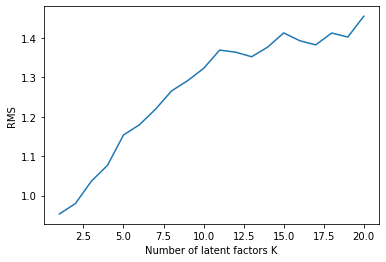

The model with the best RMS has  1 latent factors
Best RMS: 0.9536


In [20]:
plt.plot(Kvals, rmsLF)
plt.xlabel('Number of latent factors K')
plt.ylabel('RMS')
plt.show()
i = np.argmin(rmsLF)
print('The model with the best RMS has ', Kvals[i], 'latent factors')
print('Best RMS: '+'{:.4f}'.format(rmsLF[i]))

<b>Problem 2.</b> In this problem we will learn hidden Markov models (HMM) of the statistics of English text.  Each discrete time point will correspond to a single letter and for training we use a chapter from Lewis Carroll's Alice's Adventures in Wonderland.  Punctuation has been removed and all letters are lower-case.  

We will use alternatively the AIC and BIC to select the optimal number of HMM states.  They are,
$$
\mbox{AIC}:= \log p (x | \theta_M ) - d (M)
$$
and
$$
\mbox{BIC} := \log p (x | \theta_M) - \frac{1}{2} d (M) \log (T)
$$
Here, $p(x | \theta_M)$ is the likelihood of the data with the learned HMM parameters $\theta_M$, $d(M)$ are the number of parameters in the HMM and $T$ is the text length.

<b>2.a)</b> Fit a HMM with state space sizes $K=1, 5, 10, 15, 20, 30, 40, 50, 60$.  For each of this choices run the EM algorithm for at most 500 iterations or until the change in log-likelihood falls below $10^{-6}$.  Compute the log-likelihood that each model assigns to the training sequence. 

In [1]:
import numpy as np
import imp
import hw9
imp.reload(hw9)
train, test = hw9.loadText('aliceTrain.txt'), hw9.loadText('aliceTest.txt')
Kvals = [1, 5, 10, 15, 20, 30, 40, 50, 60]

In [5]:
imp.reload(hw9)
models={}
params = {}
logLL = {}
for K in Kvals:
    mod = hw9.hMM(K)
    mod.fit(train, 27)
    models[str(K)]=mod
    params[str(K)]=mod.params
    logLL[str(K)]=mod.ll[-1]

Tolerance reached!
Tolerance reached!
Max iterations reached
Max iterations reached
Tolerance reached!
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached


In [6]:
import pickle
pickle.dump(params, open('params.pkl', 'wb'))

<b>2.b)</b> Plot the AIC, BIC and log likelihood vs the number of states for the HMMs learned in (a).

In [10]:
import matplotlib.pyplot as plt
imp.reload(hw9)
n = len(Kvals)
LL, AIC, BIC = [], [], []
for i, K in enumerate(Kvals):
    LL.append(-logLL[str(K)])
    AIC.append(hw9.aic(LL[i], K, 27))
    BIC.append(hw9.bic(LL[i], 27, K, len(train)))

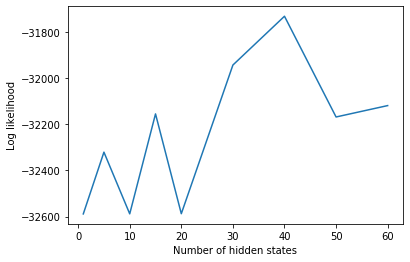

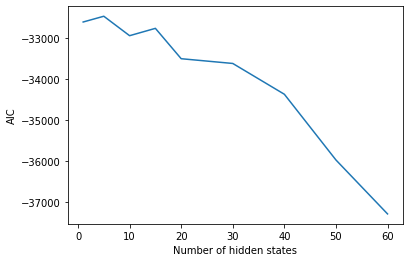

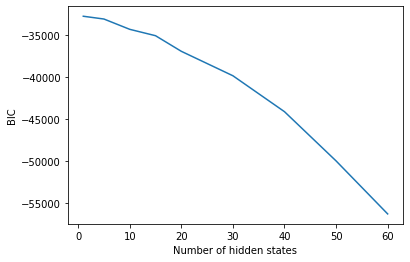

In [15]:
plt.plot(Kvals, LL)
plt.xlabel('Number of hidden states')
plt.ylabel('Log likelihood')
plt.show()
plt.plot(Kvals, AIC)
plt.xlabel('Number of hidden states')
plt.ylabel('AIC')
plt.show()
plt.plot(Kvals, BIC)
plt.xlabel('Number of hidden states')
plt.ylabel('BIC')
plt.show()

<b>2.c)</b> Calculate the log likelihood of the test data for each model learned in (a).  Which model has the best test performance?

In [16]:
testLL = []
for K in Kvals:
    testLL.append(models[str(K)].calcLL(test))

In [18]:
print('The model with the best test performance has ', Kvals[np.argmax(testLL)], 'states')

The model with the best test performance has  20 states


<b>2.d)</b> Generate a random 500-character sequence from three different HMMs: the simplest, $M=1$, the one with the highest BIC and the most complex $M=60$.

In [23]:
mod1 = models['1']
mod60 = models['60']
modBIC = models[str(Kvals[np.argmax(BIC)])]
print('   Random text sample from simplest model: '+hw9.num_to_word(mod1.sample(500)))
print('   Random text sample from most complex model:' +hw9.num_to_word(mod60.sample(500)))
print('  Random text sample from best BIC model:'+hw9.num_to_word(modBIC.sample(500)))

   Random text sample from simplest model:  ao iir gt e rseah  geaothcd iee rro tnnh eiiihltyw niueiotth agyiul eoslif  sinmsrea h ostey n ryee reewkodat dwtaose aata n stigtaafon shtir syuiwyl nkientnp lvnraeytth tesrsoap e it  faanh  lnsagtaspksenua i sttoraedt  maeselrd eol rhreeedcpohml ea  ut ht  r aaldra neyseetmw dy a hus  ui wii tr indts dtrrmha amth gtaenndr   keehtc s hedt aumteuresdy h  nglhaaai t suwnn iyw ediyoc tnaotrwoie  the lefaag  iai tehlahslwiatktg lcawi rpathmotd  aoah vn iaae tdhai l bsnda rncnys  somnre ks ihtu lnho
   Random text sample from most complex model: nd lshoascm cye eruthelh etaddtouhrhotifios  lr w tidc a eh  heaihehnniniat  rhneeoubec r hwn  unu difi  u forph  u rgennogitshhm ecs snte datllaatehhnaild imanarnnjrtloeeuh  hoscauol errrrtyiyaislmedrgtrieyia hotuts   etrsn  hs hat  tnob kapai ritw m rbchi ehiahebsb  tai cyeyta  te uh lhthedtfdtmewnt eednts k oe anahie   cse ne h  n r dhgrn  huheie ct  kd  twsrdsl gd hgi e  n loic odtfnion grgai nissaaia

<b>2.e)</b> Construct missing data by randomly replacing each letter in the test data set with a special character (e.g., an asterisk) with probability $\varepsilon = 0.2$.  Suppose that we observe an erasure at site $t$; calculate the marginal distribution $p (z_t | y)$ where where $z_t$ denotes the states of the HMM and $y$ is the observed data.

Predict the missing character by taking the mode of the distribution,
$$
p (x_t | y, y_t = *)  \propto \sum_{z_t} p (x_t | z_t ) p (z_t | y)
$$

Report the prediction accuray of each of the three models from (d).

In [4]:
miss = hw9.deleteChars(test, 27, 0.2)
mod1, modBIC, mod60 = hw9.loadMod() #load trained parameters from above code

In [10]:
out1 = mod1.predictMissing(miss, 0.2)
outBIC= modBIC.predictMissing(miss, 0.2)
out60 = mod60.predictMissing(miss, 0.2)

In [11]:
imp.reload(hw9)
acc1 = hw9.predictAcc(test, out1, miss)
accBIC = hw9.predictAcc(test, outBIC, miss)
acc60 = hw9.predictAcc(test, out60, miss)

In [12]:
print('Accuracy of simplest model: '+'{:4f}'.format(acc1))
print('Accuracy of most complex model: '+'{:4f}'.format(acc60))
print('Accuracy of model with best BIC: '+'{:4f}'.format(accBIC))

Accuracy of simplest model: 0.182231
Accuracy of most complex model: 0.188794
Accuracy of model with best BIC: 0.182231
